In [4]:
%matplotlib inline
# OPTIONAL: Load the "autoreload" extension so that the code can change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from pathlib import Path
import urllib
import zipfile
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import (
    base,
    compose,
    datasets,
    ensemble,
    metrics,
    model_selection,
    pipeline,
    preprocessing,
)
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection
from yellowbrick import classifier
import dtreeviz
from src.data.Utils import Utils
from src.data.KagTransformer import TweakKagTransformer

In [6]:
plt.style.use("ggplot")

# Set Variables

In [7]:
url: str = (
    "https://github.com/mattharrison/datasets/raw/master/data/" "kaggle-survey-2018.zip"
)
folder_name: str = "kaggle-survey-2018.zip"
member_name: str = "multipleChoiceResponses.csv"

In [39]:
# Paths
HOME: Path = Path.cwd().parents
data_folder: str = HOME[1] / f"data/raw/{folder_name}"
figures_folder: str = HOME[1] / "reports/figures"

### Datasets

In [9]:
raw = Utils.extract_zip(src=url, dst=data_folder, member_name=member_name)

## Create raw X and raw y

In [11]:
kag_X, kag_y = Utils.get_rawx_y(df=raw, y_col="Q6")

## Splitdata

In [12]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(
    kag_X, kag_y, test_size=0.3, random_state=42, stratify=kag_y
)

## Trasform X with pipeline

In [13]:
kag_pl = pipeline.Pipeline(
    [
        ("tweak", TweakKagTransformer()),
        (
            "cat",
            encoding.OneHotEncoder(
                top_categories=5, drop_last=True, variables=["Q1", "Q3", "major"]
            ),
        ),
        (
            "num_impute",
            imputation.MeanMedianImputer(
                imputation_method="median", variables=["education", "years_exp"]
            ),
        ),
    ]
)

In [16]:
X_train = kag_pl.fit_transform(kag_X_train)
X_test = kag_pl.transform(kag_X_test)

## Transform y with label encoder

In [15]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined data for cross validation/etc

In [18]:
X = pd.concat([X_train, X_test])
y = pd.Series([*y_train, *y_test], index=X.index)

## A boosted model

In [19]:
xg_oob = xgb.XGBClassifier()

In [20]:
xg_oob.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [22]:
xg_oob.score(X_test, y_test)

0.7458563535911602

*Let's try w/ depth of 2 and 2 trees*

In [23]:
xg2 = xgb.XGBClassifier(max_depth=2, n_estimators=2)

In [24]:
xg2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [25]:
xg2.score(X_test, y_test)

0.6685082872928176

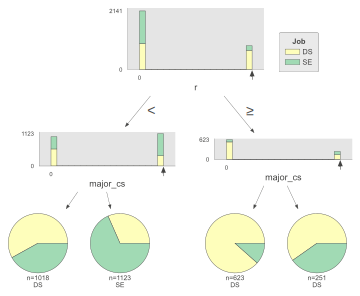

In [29]:
viz = dtreeviz.model(
    xg2,
    X_train=X,
    y_train=y,
    target_name="Job",
    feature_names=list(X_train.columns),
    class_names=["DS", "SE"],
    tree_index=0,
)
viz.view(depth_range_to_display=[0, 2])

<Axes: >

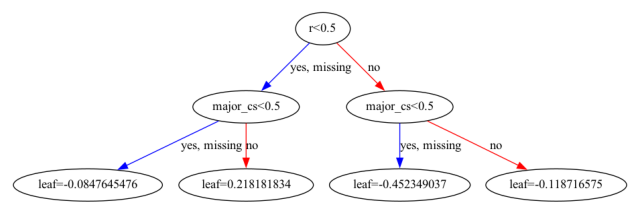

In [45]:
xgb.plot_tree(xg2, num_trees=0)